# M3 N1 Introduction to pandas and cloud based data

In this notebook, we'll wrangle some cloud-hosted data with `pandas`, and introduce some of the methods you'll use in Module 3's homework.

You'll may to install a few new packages for this assignment, so be sure to install them in the class conda environment, which is `xarray-climate` for most users.

All right, for this notebook, and for your assignment, we'll be using the NOAA Global Historical Climatology Network Daily (GHCN-D) database, which is the official record for daily weather observations.  The dataset is produced by the National Centers for Environmental Information https://doi.org/10.7289/V5D21VHZ.  As part of the NOAA Big Data project, this dataset is hosted in the cloud by several popular cloud data services. For this assignment, we'll use the service on Amazon Web Services, who hosts the dataset in an S3 bucket in a few formats. The link to the S3 page for GHCN-D is https://registry.opendata.aws/noaa-ghcn/.

The data is produced in its original format in fixed-width format text files.  We'll use `pandas` to load some metadata - the station inventory file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from datetime import datetime
import numpy as np

In [2]:
# Check Station identifiers and locate Omaha (USW00014942)
stn_ids = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', header = None, infer_nrows = 1000)
stn_ids.columns = ['ID', 'LAT', 'LON', 'ELEV', 'UKN', 'NAME', 'GSN', 'WBAN']
stn_ids

,ID,LAT,LON,ELEV,UKN,NAME,GSN,WBAN
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,41196.0
3,AEM00041194,25.2550,55.3640,10.4,NaN,DUBAI INTL,NaN,41194.0
4,AEM00041217,24.4330,54.6510,26.8,NaN,ABU DHABI INTL,NaN,41217.0
...,...,...,...,...,...,...,...,...
129653,ZI000067969,-21.0500,29.3670,861.0,NaN,WEST NICHOLSON,NaN,67969.0
129654,ZI000067975,-20.0670,30.8670,1095.0,NaN,MASVINGO,NaN,67975.0
129655,ZI000067977,-21.0170,31.5830,430.0,NaN,BUFFALO RANGE,NaN,67977.0
129656,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,67983.0


The next file we'll open is the station inventory file.  It describes for each site and each variable, the years that each variable is available.

In [3]:
# Open station inventory file to view variables
periods = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-inventory.txt', header = None, infer_nrows = 1000)
periods.columns = ['ID', 'LAT', 'LON', 'ELEM', 'TiMIN', 'TiMAX']
periods

,ID,LAT,LON,ELEM,TiMIN,TiMAX
0,ACW00011604,17.1167,-61.7833,TMAX,1949,1949
1,ACW00011604,17.1167,-61.7833,TMIN,1949,1949
2,ACW00011604,17.1167,-61.7833,PRCP,1949,1949
3,ACW00011604,17.1167,-61.7833,SNOW,1949,1949
4,ACW00011604,17.1167,-61.7833,SNWD,1949,1949
...,...,...,...,...,...,...
767020,ZI000067983,-20.2000,32.6160,PRCP,1951,2025
767021,ZI000067983,-20.2000,32.6160,TAVG,1962,2025
767022,ZI000067991,-22.2170,30.0000,TMAX,1951,1990
767023,ZI000067991,-22.2170,30.0000,TMIN,1951,1990


Let's use `pandas` to merge these two tables into one based on the ID.

In [4]:
# Merge both tables into one large table using station ID
merged_stns = pd.merge(stn_ids, periods, how = 'left', left_on = 'ID', right_on = 'ID')
merged_stns

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
0,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,TMAX,1949.0,1949.0
1,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,TMIN,1949.0,1949.0
2,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,PRCP,1949.0,1949.0
3,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,SNOW,1949.0,1949.0
4,ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,17.1167,-61.7833,SNWD,1949.0,1949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767057,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,67983.0,-20.2000,32.6160,PRCP,1951.0,2025.0
767058,ZI000067983,-20.2000,32.6160,1132.0,NaN,CHIPINGE,GSN,67983.0,-20.2000,32.6160,TAVG,1962.0,2025.0
767059,ZI000067991,-22.2170,30.0000,457.0,NaN,BEITBRIDGE,NaN,67991.0,-22.2170,30.0000,TMAX,1951.0,1990.0
767060,ZI000067991,-22.2170,30.0000,457.0,NaN,BEITBRIDGE,NaN,67991.0,-22.2170,30.0000,TMIN,1951.0,1990.0


Let's filter the merged table just for the `TMAX` element, and those stations still reporting in 2025.  Notice how the number of stations drops - most of the stations in the dataset measure rainfall & many stations have stopped reporting.

In [5]:
# Subset for T
merged_stns = merged_stns[(merged_stns['ELEM'] == 'TMAX') & (merged_stns['TiMAX'] == 2025)]
merged_stns

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
18,AE000041196,25.3330,55.517,34.0,NaN,SHARJAH INTER. AIRP,GSN,41196.0,25.3330,55.517,TMAX,1944.0,2025.0
22,AEM00041194,25.2550,55.364,10.4,NaN,DUBAI INTL,NaN,41194.0,25.2550,55.364,TMAX,1983.0,2025.0
26,AEM00041217,24.4330,54.651,26.8,NaN,ABU DHABI INTL,NaN,41217.0,24.4330,54.651,TMAX,1983.0,2025.0
30,AEM00041218,24.2620,55.609,264.9,NaN,AL AIN INTL,NaN,41218.0,24.2620,55.609,TMAX,1994.0,2025.0
54,AG000060390,36.7167,3.250,24.0,NaN,ALGER-DAR EL BEIDA,GSN,60390.0,36.7167,3.250,TMAX,1940.0,2025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
766989,ZA000067743,-17.8170,25.817,986.0,NaN,LIVINGSTONE,GSN,67743.0,-17.8170,25.817,TMAX,1973.0,2025.0
766994,ZAM00067663,-14.4500,28.467,1207.0,NaN,KABWE/MILLIKEN,NaN,67663.0,-14.4500,28.467,TMAX,1973.0,2025.0
767006,ZI000067775,-17.9170,31.133,1480.0,NaN,HARARE (KUTSAGA),GSN,67775.0,-17.9170,31.133,TMAX,1956.0,2025.0
767047,ZI000067975,-20.0670,30.867,1095.0,NaN,MASVINGO,NaN,67975.0,-20.0670,30.867,TMAX,1951.0,2025.0


Let's visualize where these currently reporting stations are using a map, depending on when they started taking measurements.  We'll sort them so the oldest ones are last, so they plot on the top of the map.

In [6]:
# Sort stations based on station status
merged_stns_sorted = merged_stns.sort_values('TiMIN', ascending = False)

In [7]:
merged_stns_sorted

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
631843,USC00388473,35.0644,-82.6722,384.0,SC,TABLE ROCK RSVR,NaN,NaN,35.0644,-82.6722,TMAX,2025.0,2025.0
488752,USC00126988,41.5919,-85.1017,324.9,IN,PLEASANT LAKE 4NW,NaN,NaN,41.5919,-85.1017,TMAX,2025.0,2025.0
624492,USC00364571,41.8422,-79.0169,384.0,PA,KINZUA DAM,NaN,NaN,41.8422,-79.0169,TMAX,2025.0,2025.0
136606,IN009021100,15.8500,74.5330,753.0,NaN,BELGAUM,NaN,43197.0,15.8500,74.5330,TMAX,2025.0,2025.0
136896,IN009170500,16.2000,77.3500,400.0,NaN,RAICHUR,NaN,43169.0,16.2000,77.3500,TMAX,2025.0,2025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180321,UK000047811,54.3500,-6.6500,62.0,NaN,ARMAGH,NaN,NaN,54.3500,-6.6500,TMAX,1844.0,2025.0
734385,USW00014734,40.6828,-74.1692,1.8,NJ,NEWARK LIBERTY INTL AP,NaN,72502.0,40.6828,-74.1692,TMAX,1843.0,2025.0
63013,BE000006447,50.8000,4.3500,104.0,NaN,UCCLE,GSN,6447.0,50.8000,4.3500,TMAX,1833.0,2025.0
129318,GM000004204,50.9267,11.5842,155.0,NaN,JENA STERNWARTE,NaN,NaN,50.9267,11.5842,TMAX,1824.0,2025.0


Let's do a scatter plot on a `cartopy` map.

Text(0.5, 1.0, 'GHCN Data Reporting Stations')

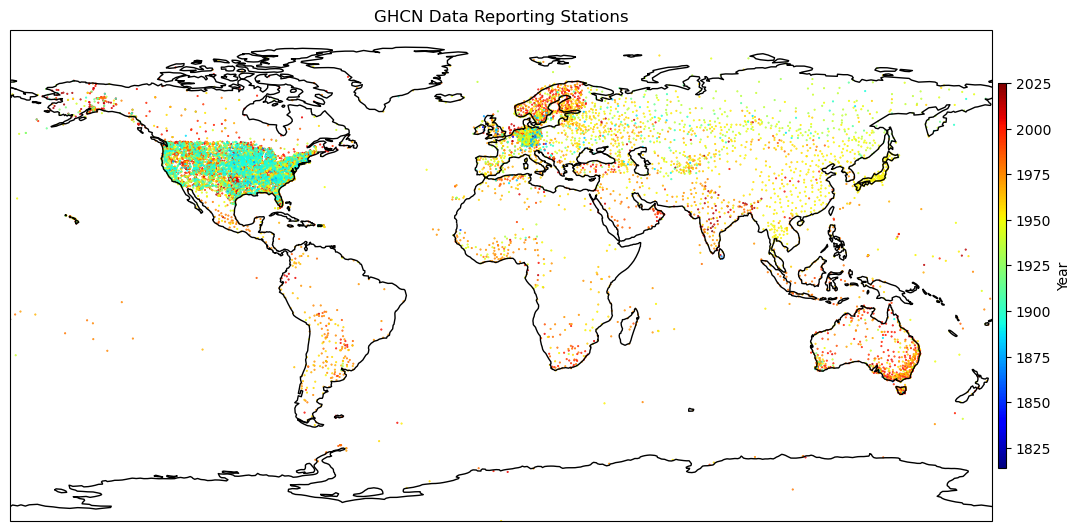

In [9]:
# Plot scatter 
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())

# Make the map global rather than have it zoom in to the extents of any plotted data
ax.set_global()
ax.coastlines()

plt.scatter(merged_stns_sorted['LON_x'], merged_stns_sorted['LAT_x'], 0.25, c = merged_stns_sorted['TiMIN'], 
            transform = ccrs.PlateCarree(), cmap = 'jet')
plt.colorbar(shrink = 0.5, label = 'Year', aspect = 50, pad = 0.005)
plt.title('GHCN Data Reporting Stations')

Let's do a query to find stations that are reporting in 2025 and contain the string 'CHAMPAIGN' the station name field.

In [10]:
# Changing to Omaha, NE instead of Champaign, IL 
merged_stns[merged_stns['NAME'].str.contains('OMAHA', regex = False)]

,ID,LAT_x,LON_x,ELEV,UKN,NAME,GSN,WBAN,LAT_y,LON_y,ELEM,TiMIN,TiMAX
688770,USC00477142,45.5378,-89.7322,445.0,WI,RICE RSVR TOMAHAWK-2,NaN,NaN,45.5378,-89.7322,TMAX,1998.0,2025.0
739508,USW00014942,41.3119,-95.9019,298.7,NE,OMAHA EPPLEY AIRFIELD,NaN,72550.0,41.3119,-95.9019,TMAX,1948.0,2025.0


Let's load the data! The data is avaiable in AWS in a couple of formats.  It has a mirror of the raw data format in column separated values (csv), and pandas can read it without a problem.  I've added a couple of flags to avoid errors, but this should work to open the data in this format.

Again, to learn more, visit the AWS site for GHCN-D (https://registry.opendata.aws/noaa-ghcn/)

Let's load 

In [11]:
# Changed station from USC00118740 to USW00014942
df = pd.read_csv("s3://noaa-ghcn-pds/csv/by_station/USW00014942.csv", storage_options = {"anon": True},
                 dtype = {'Q_FLAG': 'object', 'M_FLAG': 'object'}, parse_dates = ['DATE']).set_index('DATE')

Looking at the structure of the data, each "element" takes up one line, there are QC flags for each variables, and other informtion.

In [12]:
df

,ID,ELEMENT,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME
DATE,,,,,,,
1948-01-01,USW00014942,TMAX,-67,NaN,NaN,X,NaN
1948-01-02,USW00014942,TMAX,-28,NaN,NaN,X,NaN
1948-01-03,USW00014942,TMAX,56,NaN,NaN,X,NaN
1948-01-04,USW00014942,TMAX,44,NaN,NaN,X,NaN
1948-01-05,USW00014942,TMAX,44,NaN,NaN,X,NaN
...,...,...,...,...,...,...,...
2025-02-02,USW00014942,WSF5,58,NaN,NaN,W,NaN
2025-02-03,USW00014942,WSF5,161,NaN,NaN,W,NaN
2025-02-04,USW00014942,WSF5,130,NaN,NaN,W,NaN


We can also load the data in a parquet format, which is a cloud-optimized database format.  It also works well with `dask`.  We won't use `dask` for this exercise because a single site is a small file.  However, if you were interested in looking at larger portions of the dataset, `dask` could help.

In [13]:
# Load alternatively using Parquet
df = pd.read_parquet("s3://noaa-ghcn-pds/parquet/by_station/STATION=USW00014942/", storage_options = {"anon": True})

In [14]:
# Make date the index
df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(x, '%Y%m%d')))
df = df.set_index('DATE').sort_index()  # We need to sort by time because the files are sorted to be arbitrary
df

,ID,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,ELEMENT
DATE,,,,,,,
1948-01-01,USW00014942,51,None,None,X,None,SNWD
1948-01-01,USW00014942,1,None,None,X,None,WT18
1948-01-01,USW00014942,-67,None,None,X,None,GAHT
1948-01-01,USW00014942,1,None,None,X,None,WT09
1948-01-01,USW00014942,-67,None,None,X,None,TMAX
...,...,...,...,...,...,...,...
2025-02-06,USW00014942,0,None,None,D,2400,PRCP
2025-02-06,USW00014942,0,None,None,D,None,SNOW
2025-02-06,USW00014942,0,None,None,D,None,SNWD


Let's create separate dataframes for elements of interest: Maximum and Minimum Temperature and Precipitaion.

In [15]:
df_tmax = df.loc[df['ELEMENT'] == 'TMAX']
df_tmin = df.loc[df['ELEMENT'] == 'TMIN']
df_prcp = df.loc[df['ELEMENT'] == 'PRCP']

In [16]:
df_tmax

,ID,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,ELEMENT
DATE,,,,,,,
1948-01-01,USW00014942,-67,None,None,X,None,TMAX
1948-01-02,USW00014942,-28,None,None,X,None,TMAX
1948-01-03,USW00014942,56,None,None,X,None,TMAX
1948-01-04,USW00014942,44,None,None,X,None,TMAX
1948-01-05,USW00014942,44,None,None,X,None,TMAX
...,...,...,...,...,...,...,...
2025-02-02,USW00014942,144,None,None,W,2400,TMAX
2025-02-03,USW00014942,61,None,None,W,2400,TMAX
2025-02-04,USW00014942,-38,None,None,W,2400,TMAX


Note that the values are a not a magnitude you might expect - they are scaled integers.  To get values in degrees C, divide the values by 10.

## Pandas Plotting

So, let's visualize this data using `matplotlib`. 

In [17]:
%matplotlib inline

Ok, let's plot the time series of maximum temperature for the station we loaded above.  We'll add a fancy rangetool to show the data.

In [18]:
df_tmax

,ID,DATA_VALUE,M_FLAG,Q_FLAG,S_FLAG,OBS_TIME,ELEMENT
DATE,,,,,,,
1948-01-01,USW00014942,-67,None,None,X,None,TMAX
1948-01-02,USW00014942,-28,None,None,X,None,TMAX
1948-01-03,USW00014942,56,None,None,X,None,TMAX
1948-01-04,USW00014942,44,None,None,X,None,TMAX
1948-01-05,USW00014942,44,None,None,X,None,TMAX
...,...,...,...,...,...,...,...
2025-02-02,USW00014942,144,None,None,W,2400,TMAX
2025-02-03,USW00014942,61,None,None,W,2400,TMAX
2025-02-04,USW00014942,-38,None,None,W,2400,TMAX


We'll use the builtin plotting capability of pandas to create a plot.  Since the index is set to the date and it is a datetime object, we can just plot away.  We can't forget to scale the data!

<Axes: xlabel='DATE'>

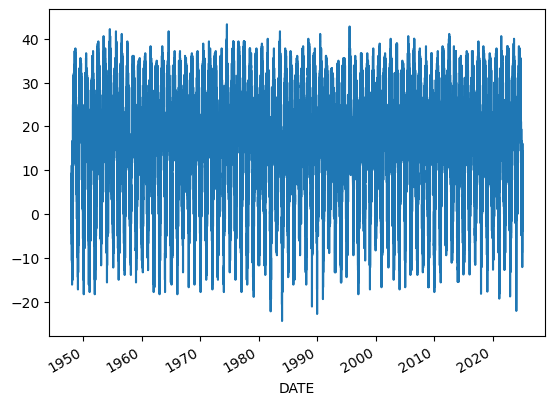

In [19]:
# Plot Max T
(df_tmax['DATA_VALUE'] / 10.).plot()

Let's create an annual mean minimum temperature time series using `pandas` groupby.  For convenience, I am going to drop the leap year observations first.

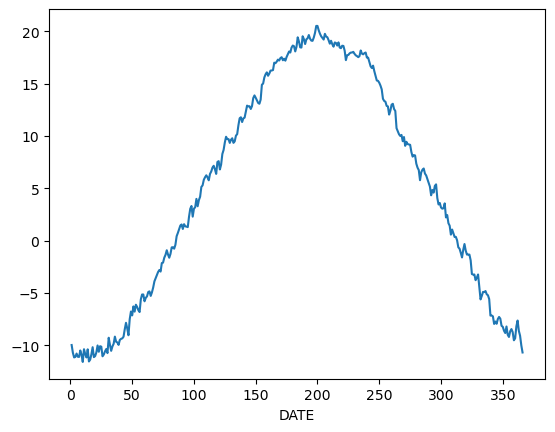

In [20]:
Oma_Series = df_tmin[~((df_tmin.index.month == 2) & (df_tmin.index.day == 29))]

bk_bar1 = (Oma_Series['DATA_VALUE'] / 10.).groupby(Oma_Series.index.day_of_year).mean().plot()

It's easy to create basing plots using `pandas_bokeh`, but you can also using the `bokeh` interface to make plots similar to a matplotlib-type plot.  Here, let's show the maximum temperatures for 2022.

<Axes: xlabel='DATE'>

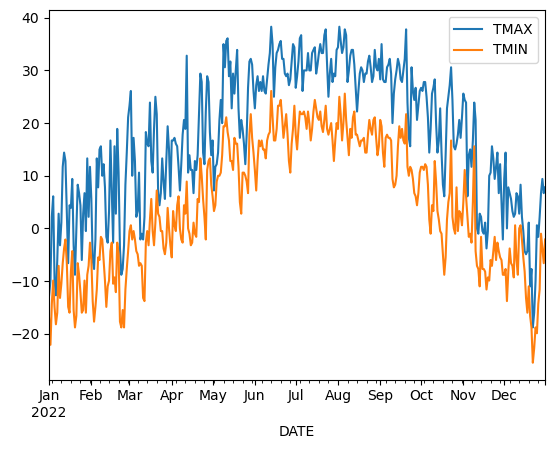

In [21]:
df_2022 = df_tmax[(df_tmax.index >= pd.to_datetime('2022-01-01')) & (df_tmax.index <= pd.to_datetime('2022-12-31'))]
df_2_2022 = df_tmin[(df_tmin.index >= pd.to_datetime('2022-01-01')) & (df_tmin.index <= pd.to_datetime('2022-12-31'))]

df_extremes = pd.DataFrame({'TMAX':df_2022['DATA_VALUE']/10., 'TMIN':df_2_2022['DATA_VALUE'] / 10.}, index = df_2022.index)

df_extremes.plot()

Let's make a histogram of low temperatures

In [22]:
# Omaha's dataset began in 1948 at Eppley Field
# Adjust range from 1901 (Champaign) to 1951 (Omaha) to have comparable 30-year span.

# Histogram of low temperatures 
arr_hist, edges = np.histogram(df_tmin['DATA_VALUE'][(df_tmin.index >= '1991-01-01') & (df_tmin.index < '2020-01-01')] / 10., 
                               bins = np.arange(-40, 47, 2.5), density = True)
# Put the information in a dataframe
temps = pd.DataFrame({'hist': arr_hist, 'left': edges[:-1], 'right': edges[1:]})

arr_hist, edges = np.histogram(df_tmin['DATA_VALUE'][(df_tmin.index >= '1951-01-01') & (df_tmin.index < '1980-01-01')] / 10., 
                               bins = np.arange(-40, 47, 2.5), density = True)
# Put the information in a dataframe
temps2 = pd.DataFrame({'hist': arr_hist, 'left': edges[:-1], 'right': edges[1:]})

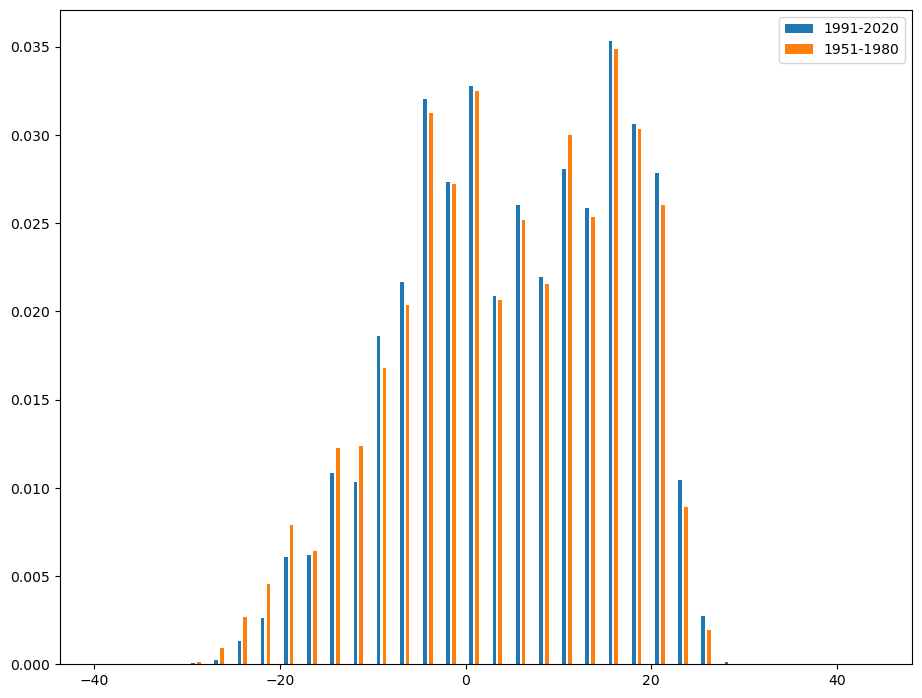

In [23]:
# Histogram plot (°C)
plt.figure(figsize = (11, 8.5))

plt.bar(temps['left'].values + (temps['right'].values - temps['left'].values) / 4., temps['hist'].values, width = .4, label = '1991-2020')
plt.bar(temps2['left'].values + (temps2['right'].values - temps2['left'].values) / 2., temps2['hist'].values, width = .4, label = '1951-1980')
plt.legend()

Temperature Statistics (1991-2020):
   record_min_temp  average_min_temp  average_max_temp  record_max_temp
0            -30.6          5.324637         16.998954             43.3

Temperature Statistics (1951-1980):
   record_min_temp  average_min_temp  average_max_temp  record_max_temp
0            -30.6          4.637036          16.62714             43.3


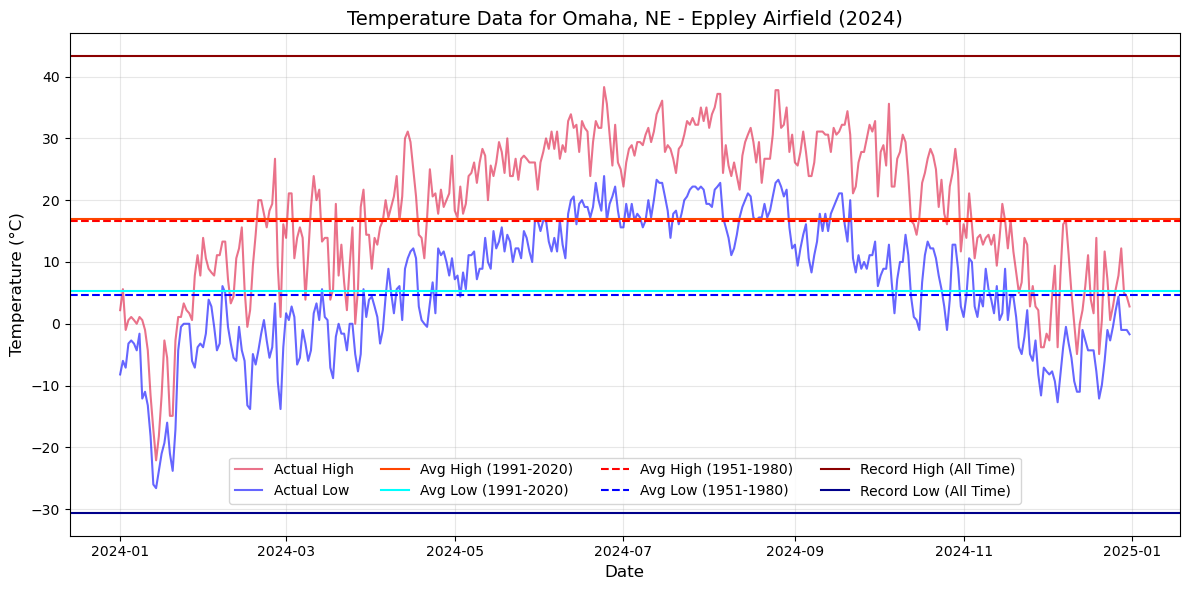

In [26]:
def get_station_temperature_stats(station_id, year = 2024):
    """
    Downloads GHCN Daily Data for a given station ID, calculates all-time record high/low
    and 1991-2020 and 1951-1980 mean high/low temperatures, and returns DataFrames with these statistics.
    
    Parameters:
    - station_id (str): GHCN station ID (e.g., 'USW00014942')
    - year (int): Year for which to retrieve actual temperatures (default: 2024)
    
    Returns:
    - stats_df (pd.DataFrame): DataFrame with columns ['record_min_temp', 'average_min_temp',
      'average_max_temp', 'record_max_temp'] for 1991-2020
    - stats_df1 (pd.DataFrame): DataFrame with columns ['record_min_temp', 'average_min_temp',
      'average_max_temp', 'record_max_temp'] for 1951-1980
    - yearly_df (pd.DataFrame): DataFrame with actual TMAX and TMIN for the specified year
    """
    # Load data from AWS S3
    try:
        df = pd.read_parquet(
            f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/",
            storage_options={"anon": True}
        )
        df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(x, '%Y%m%d')))
        df = df.set_index('DATE').sort_index()
    except Exception as e:
        print(f"Error loading data for station {station_id}: {e}")
        return None, None, None

    # Filter for TMAX and TMIN elements
    df_tmax = df[df['ELEMENT'] == 'TMAX'].copy()
    df_tmin = df[df['ELEMENT'] == 'TMIN'].copy()

    # Convert DATA_VALUE to Celsius (divide by 10)
    df_tmax['DATA_VALUE'] = df_tmax['DATA_VALUE'] / 10.0
    df_tmin['DATA_VALUE'] = df_tmin['DATA_VALUE'] / 10.0

    # Calculate all-time record high and low
    record_max_temp = df_tmax['DATA_VALUE'].max()
    record_min_temp = df_tmin['DATA_VALUE'].min()

    # Calculate 1991-2020 mean high and low temperatures
    df_tmax_1991_2020 = df_tmax[(df_tmax.index >= '1991-01-01') & (df_tmax.index <= '2020-12-31')]
    df_tmin_1991_2020 = df_tmin[(df_tmin.index >= '1991-01-01') & (df_tmin.index <= '2020-12-31')]
    average_max_temp = df_tmax_1991_2020['DATA_VALUE'].mean()
    average_min_temp = df_tmin_1991_2020['DATA_VALUE'].mean()

    # Calculate 1951-1980 mean high and low temperatures
    df_tmax_1951_1980 = df_tmax[(df_tmax.index >= '1951-01-01') & (df_tmax.index <= '1980-12-31')]
    df_tmin_1951_1980 = df_tmin[(df_tmin.index >= '1951-01-01') & (df_tmin.index <= '1980-12-31')]
    average_max_temp1 = df_tmax_1951_1980['DATA_VALUE'].mean()
    average_min_temp1 = df_tmin_1951_1980['DATA_VALUE'].mean()

    # Create statistics DataFrame for 1991-2020
    stats_df = pd.DataFrame({
        'record_min_temp': [record_min_temp],
        'average_min_temp': [average_min_temp],
        'average_max_temp': [average_max_temp],
        'record_max_temp': [record_max_temp]
    })

    # Create statistics DataFrame for 1951-1980
    stats_df1 = pd.DataFrame({
        'record_min_temp': [record_min_temp],
        'average_min_temp': [average_min_temp1],
        'average_max_temp': [average_max_temp1],
        'record_max_temp': [record_max_temp]
    })

    # Extract data for the specified year
    df_tmax_year = df_tmax[(df_tmax.index >= f'{year}-01-01') & (df_tmax.index <= f'{year}-12-31')]
    df_tmin_year = df_tmin[(df_tmin.index >= f'{year}-01-01') & (df_tmin.index <= f'{year}-12-31')]
    yearly_df = pd.DataFrame({
        'TMAX': df_tmax_year['DATA_VALUE'],
        'TMIN': df_tmin_year['DATA_VALUE']
    })

    return stats_df, stats_df1, yearly_df

def plot_temperature_data(stats_df, stats_df1, yearly_df, station_name, year=2024):
    """
    Creates a matplotlib plot showing record, average (1991-2020 and 1951-1980), and actual
    high/low temperatures for a given year and station.
    
    Parameters:
    - stats_df (pd.DataFrame): DataFrame with temperature statistics for 1991-2020
    - stats_df1 (pd.DataFrame): DataFrame with temperature statistics for 1951-1980
    - yearly_df (pd.DataFrame): DataFrame with actual TMAX and TMIN for the year
    - station_name (str): Name of the station (e.g., 'Omaha, NE- Eppley Airfield')
    - year (int): Year to plot (default: 2024)
    """
    plt.figure(figsize = (12, 6))
    
    # Plot actual high and low temperatures
    plt.plot(yearly_df.index, yearly_df['TMAX'], label = 'Actual High', color = 'crimson', alpha = 0.6)
    plt.plot(yearly_df.index, yearly_df['TMIN'], label = 'Actual Low', color ='blue', alpha = 0.6)
    
    # Plot average high and low temperatures (1991-2020)
    plt.axhline(y = stats_df['average_max_temp'].iloc[0], color = 'orangered', linestyle = '-', 
                label = 'Avg High (1991-2020)')
    plt.axhline(y = stats_df['average_min_temp'].iloc[0], color = 'cyan', linestyle = '-', 
                label = 'Avg Low (1991-2020)')
    
    # Plot average high and low temperatures (1951-1980)
    plt.axhline(y = stats_df1['average_max_temp'].iloc[0], color = 'red', linestyle = '--', 
                label = 'Avg High (1951-1980)')
    plt.axhline(y = stats_df1['average_min_temp'].iloc[0], color = 'blue', linestyle = '--', 
                label = 'Avg Low (1951-1980)')
    
    # Plot record high and low temperatures
    plt.axhline(y = stats_df['record_max_temp'].iloc[0], color = 'darkred', linestyle = '-', 
                label = 'Record High (All Time)')
    plt.axhline(y = stats_df['record_min_temp'].iloc[0], color = 'darkblue', linestyle = '-', 
                label = 'Record Low (All Time)')
    
    # Customize plot
    plt.title(f'Temperature Data for {station_name} ({year})', fontsize = 14)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Temperature (°C)', fontsize = 12)
    plt.legend(bbox_to_anchor = (0.5, 0.05), loc = 'lower center', ncol = 4)
    plt.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.show()

# Parameters
station_id = 'USW00014942'  # Omaha, NE Eppley Airfield
station_name = 'Omaha, NE - Eppley Airfield'
year = 2024

# Call the function
stats_df, stats_df1, yearly_df = get_station_temperature_stats(station_id, year)

# Check if data was loaded successfully
if stats_df is not None and stats_df1 is not None and yearly_df is not None:
    print("Temperature Statistics (1991-2020):")
    print(stats_df)
    print("\nTemperature Statistics (1951-1980):")
    print(stats_df1)
    
    # Plot the data
    plot_temperature_data(stats_df, stats_df1, yearly_df, station_name, year)
else:
    print("Failed to retrieve data.")